In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


In [3]:
# mmint
data_path = '/home/mmint/Desktop/drawing_evaluation'
datalegend_path =  os.path.join(data_path, 'drawing_evaluation_DataLegend.csv')
# mik:
# data_path = '/Users/mik/Desktop/bubble_files/drawing_evaluation'
# datalegend_path = os.path.join(data_path, 'drawing_evaluation_DataLegend.csv')

df = pd.read_csv(datalegend_path)

df

,EvaluationFileCode,ReferenceFileCode,ActionsFileCode,ObjectName,SceneName,ControllerMethod,ObjectPoseEstimator,Score,NumSteps,NumStepsExpected,ObservationFileCodes
0,32,1,32,amazon,line_drawing,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,33.246501,29,40,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
1,66,33,66,amazon,line_drawing,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,21.471634,31,40,"[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4..."
2,100,67,100,amazon,line_drawing,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,29.595433,31,40,"[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 7..."
3,138,101,138,amazon,line_drawing,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,25.907281,35,40,"[102, 103, 104, 105, 106, 107, 108, 109, 110, ..."
4,175,139,175,amazon,line_drawing,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,29.912956,34,40,"[140, 141, 142, 143, 144, 145, 146, 147, 148, ..."
...,...,...,...,...,...,...,...,...,...,...,...
62,1519,1501,1519,amazon,line_drawing,object_pose_dynamics_model_mppi,BatchedModelOutputObjectPoseEstimation,137.403430,16,40,"[1502, 1503, 1504, 1505, 1506, 1507, 1508, 150..."
63,1537,1520,1537,amazon,line_drawing,object_pose_dynamics_model_mppi,BatchedModelOutputObjectPoseEstimation,140.439986,15,40,"[1521, 1522, 1523, 1524, 1525, 1526, 1527, 152..."
64,1553,1538,1553,veesa,line_drawing,object_pose_dynamics_model_mppi,BatchedModelOutputObjectPoseEstimation,157.672878,13,40,"[1539, 1540, 1541, 1542, 1543, 1544, 1545, 154..."
65,1564,1554,1564,veesa,line_drawing,object_pose_dynamics_model_mppi,BatchedModelOutputObjectPoseEstimation,206.130742,8,40,"[1555, 1556, 1557, 1558, 1559, 1560, 1561, 156..."


In [4]:
# USEFUL FUNCTIONS:
def load_drawing(fc, scene_name):
    file_path = os.path.join(data_path, scene_name, 'measured_drawing', 'color_data', '{}_color_{:06d}.npy'.format(scene_name, fc))
    with open(file_path, 'rb') as f:
        drawing = np.load(f)
    return drawing
    
def load_desired_drawing(fc, scene_name):
    file_path = os.path.join(data_path, scene_name, 'expected_drawing', 'color_data', '{}_color_{:06d}.npy'.format(scene_name, fc))
    with open(file_path, 'rb') as f:
        drawing = np.load(f)
    return drawing
    
def filter_img(img):
    tag_size = 150
    filtered_value = 0
    filtered_img = img.copy()
    filtered_img[:tag_size, :tag_size] = filtered_value
    filtered_img[:tag_size, -tag_size:] = filtered_value
    filtered_img[-tag_size:, :tag_size] = filtered_value
    filtered_img[-tag_size:, -tag_size:] = filtered_value
    return filtered_img

def add_new_cost_function(cost_function, name):
    new_scores = []
    for i, row_i in df.iterrows():
        fc = row_i['EvaluationFileCode']
        scene_name = row_i['SceneName']
        drawn_img_i = load_drawing(fc, scene_name)
        desired_img_i = load_desired_drawing(fc, scene_name)
        filtered_img_i = filter_img(drawn_img_i)
        score_i = cost_function(filtered_img_i, desired_img_i)
        new_scores.append(score_i)
    df['{}_scores'.format(name)] = new_scores

In [5]:
# SCORE FUNCTIONS:
def compute_line_mask_score(actual_drawing, desired_drawing):
    actual_drawing_line = np.sum(actual_drawing, axis=1)
    desired_drawing_line = np.sum(desired_drawing, axis=1)
    actual_drawing_norm = np.divide(actual_drawing_line.astype(np.float32), actual_drawing_line.astype(np.float32), out=np.zeros_like(actual_drawing_line, dtype=np.float32), where=actual_drawing_line!=0)
    desired_drawing_norm = np.divide(desired_drawing_line.astype(np.float32), desired_drawing_line.astype(np.float32), out=np.zeros_like(desired_drawing_line, dtype=np.float32), where=desired_drawing_line!=0)
    score = np.sum(desired_drawing_norm * actual_drawing_norm)/np.sum(desired_drawing_norm)
    return score


In [6]:
# COMPUTE SCORE STATISTICS
def compute_score_statistics(score_name):
    model_names = np.unique(df.ControllerMethod)
    results = []
    for model_name in model_names:
        model = df[df.ControllerMethod == model_name]
        scores = model[score_name].values
    #     scores = scores[np.where(scores<150)] # Consider filtering scores
        mu = np.mean(scores)
        std = np.std(scores)
        max_score = np.max(scores)
        min_score = np.min(scores)
        results.append([model_name, mu, std, max_score, min_score])
    new_results_df = pd.DataFrame(results, columns=['ModelName', 'mu', 'std', 'max_score', 'min_score'])
    return new_results_df

In [7]:
add_new_cost_function(compute_line_mask_score, 'line_masked')

In [8]:
compute_score_statistics('line_masked_scores')

,ModelName,mu,std,max_score,min_score
0,bubble_dynamics_fixed_model_mppi,0.487305,0.192438,0.802842,0.253546
1,bubble_dynamics_model_mppi,0.703095,0.166435,0.840426,0.351064
2,bubble_linear_dynamics_model_mppi,0.686689,0.205922,0.879218,0.291297
3,object_pose_dynamics_model_mppi,0.312054,0.118226,0.586879,0.124334
4,random_action,0.211696,0.139450,0.445826,0.010657


In [37]:
def score_box_plot(score_name, object_name=None):
    if object_name is not None:
        data_df = df[df.ObjectName == object_name]
    else:
        data_df = df
        object_name = np.unique(df.ObjectName) # All object names
    ax = sns.boxplot(x='ControllerMethod', y=score_name, data=data_df, whis=5)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)
    ax.set_title('Object: {}'.format(object_name))
    # ax = sns.boxplot(x='ControllerMethod', y='new_scores', data=df)
    # ax.set_xticklabels(['Learned Model + MPPI', 'Random Actions', 'Fixed Model + MPPI'])
    return ax


def score_strip_plot(score_name, object_name=None):
    if object_name is not None:
        data_df = df[df.ObjectName == object_name]
    else:
        data_df = df
        object_name = np.unique(df.ObjectName) # All object names
    ax = sns.stripplot(x='ControllerMethod', y=score_name, data=data_df)
    ax = sns.pointplot(x='ControllerMethod', y=score_name, data=data_df, join=False, palette="dark", alpha=0.1, markers="d")
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)
    ax.set_title('Object: {}'.format(object_name))
    # ax = sns.boxplot(x='ControllerMethod', y='new_scores', data=df)
    # ax.set_xticklabels(['Learned Model + MPPI', 'Random Actions', 'Fixed Model + MPPI'])
    return ax

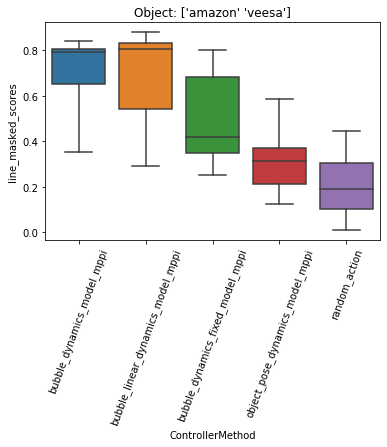

In [10]:
ax = score_box_plot('line_masked_scores', object_name=None) # ALL

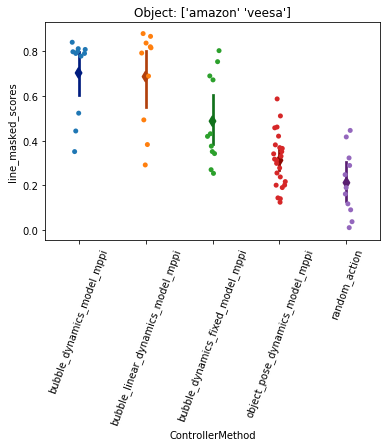

In [38]:
ax = score_strip_plot('line_masked_scores', object_name=None) # ALL

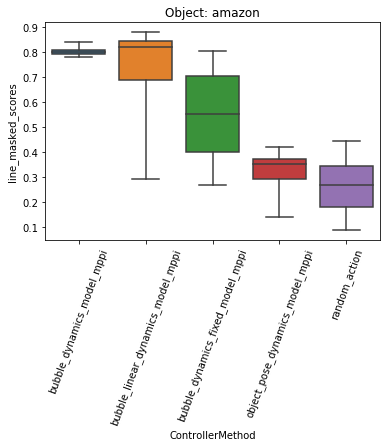

In [52]:
ax = score_box_plot('line_masked_scores', object_name='amazon')

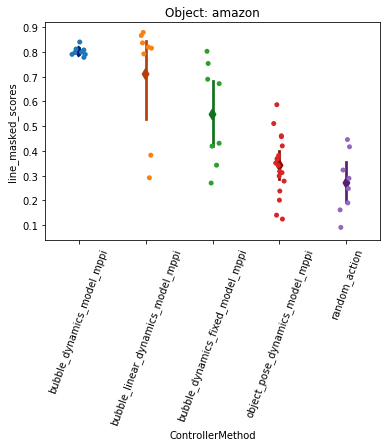

In [39]:
ax = score_strip_plot('line_masked_scores', object_name='amazon')

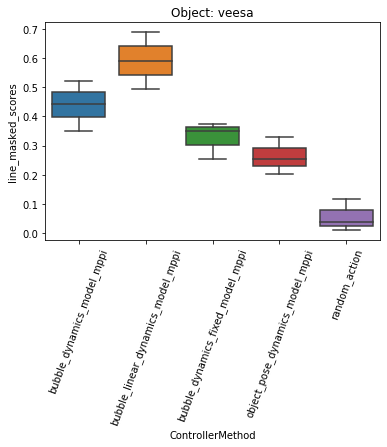

In [53]:
ax = score_box_plot('line_masked_scores', object_name='veesa')

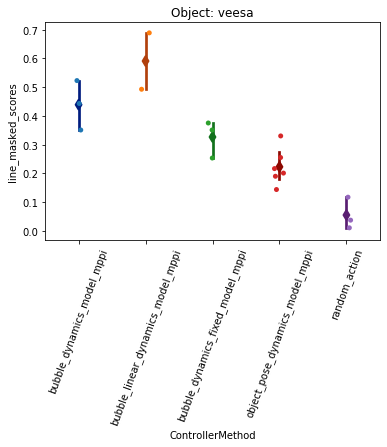

In [40]:
ax = score_strip_plot('line_masked_scores', object_name='veesa')

In [44]:
df['ControllerMethod'] = df['ControllerMethod'] + '_' + df['ObjectPoseEstimator']

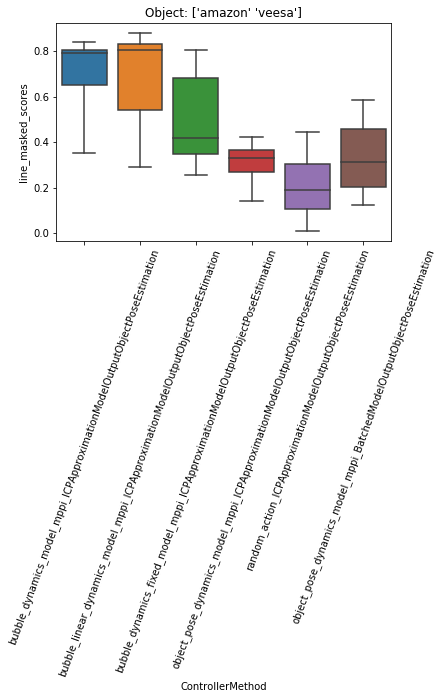

In [76]:
ax = score_box_plot('line_masked_scores', object_name=None) # ALL

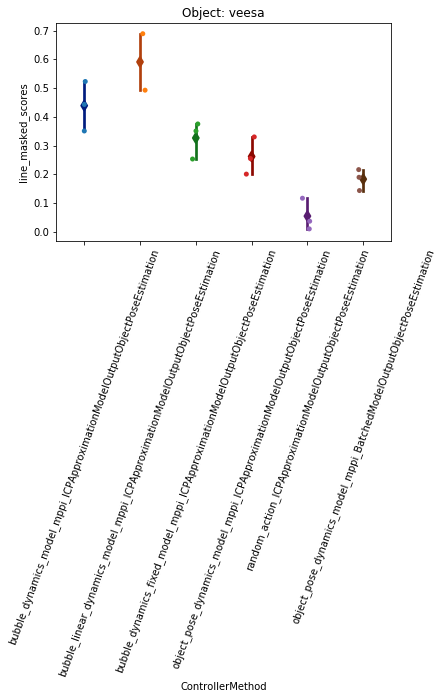

In [45]:
ax = score_strip_plot('line_masked_scores', object_name='veesa')

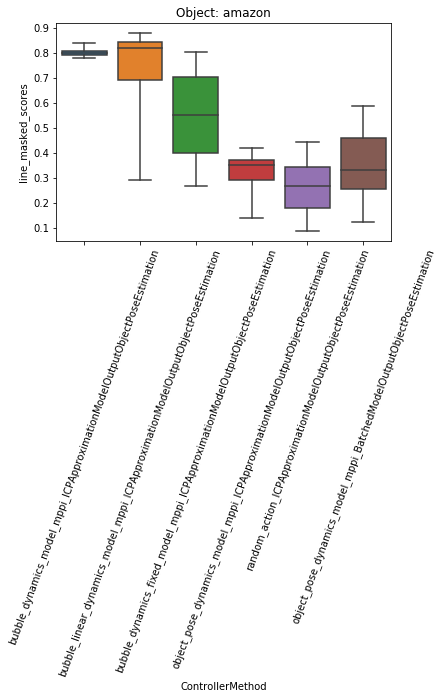

In [77]:
ax = score_box_plot('line_masked_scores', object_name='amazon') # ALL

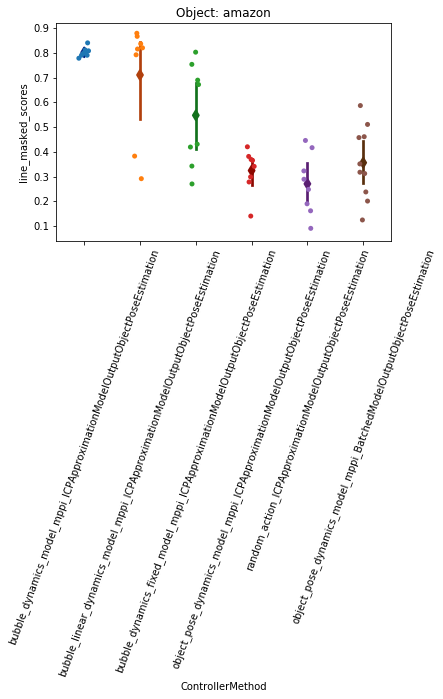

In [46]:
ax = score_strip_plot('line_masked_scores', object_name='amazon') # ALL

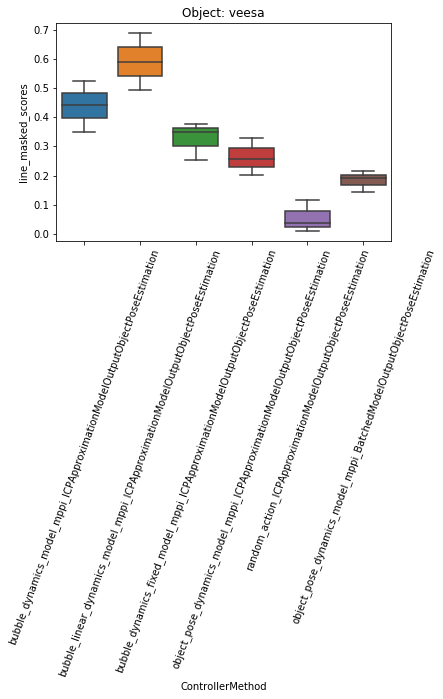

In [78]:
ax = score_box_plot('line_masked_scores', object_name='veesa') # ALL

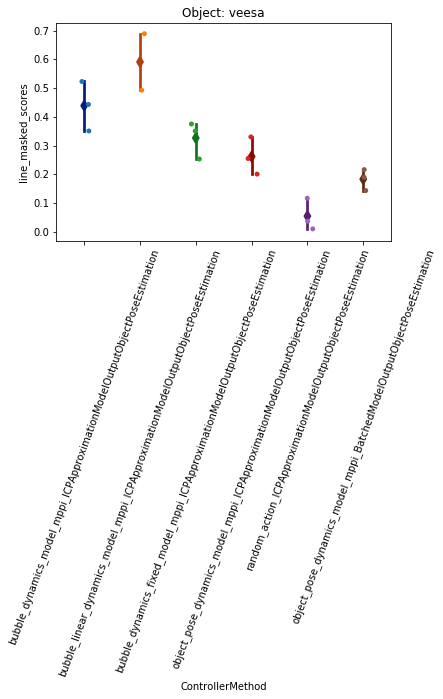

In [47]:
ax = score_strip_plot('line_masked_scores', object_name='veesa') # ALL

----

----

----

In [10]:
def compute_score(actual_drawing, desired_drawing):
    img_th = 50
    current_drawing_pixels = np.stack(np.where(actual_drawing > img_th), axis=-1)
    desired_drawing_pixels = np.stack(np.where(desired_drawing > img_th), axis=-1)
    tree = KDTree(current_drawing_pixels)
    min_dists, min_indxs = tree.query(desired_drawing_pixels)
    score = np.mean(min_dists)
    return score

In [11]:
def compute_masked_score(actual_drawing, desired_drawing):
    actual_drawing_norm = np.divide(actual_drawing.astype(np.float32), actual_drawing.astype(np.float32), out=np.zeros_like(actual_drawing, dtype=np.float32), where=actual_drawing!=0)
    desired_drawing_norm = np.divide(desired_drawing.astype(np.float32), desired_drawing.astype(np.float32), out=np.zeros_like(desired_drawing, dtype=np.float32), where=desired_drawing!=0)
    score = np.sum(desired_drawing_norm * actual_drawing_norm)
    return score

[Text(0, 0, 'Learned Model + MPPI'),
 Text(1, 0, 'Random Actions'),
 Text(2, 0, 'Fixed Model + MPPI')]

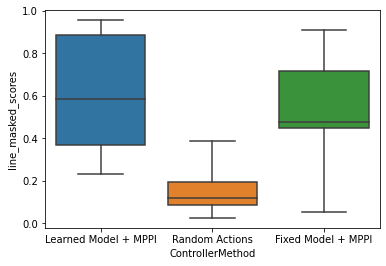

In [100]:
ax = sns.boxplot(x='ControllerMethod', y='line_masked_scores', data=df, whis=5)
# ax = sns.boxplot(x='ControllerMethod', y='new_scores', data=df)
ax.set_xticklabels(['Learned Model + MPPI', 'Random Actions', 'Fixed Model + MPPI'])

[(0.0, 1.0)]

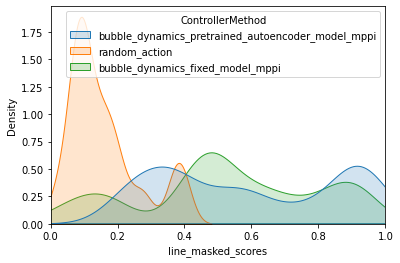

In [106]:
ax = sns.kdeplot(data=df, x='line_masked_scores', hue='ControllerMethod', fill=True, alpha=.2, bw_adjust=.5)
ax.set(xlim=(0,1))

In [97]:
np.sum(load_desired_drawing(1)>0)

551

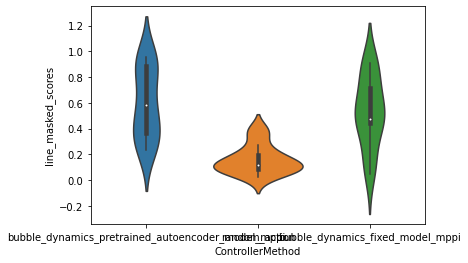

In [108]:
ax = sns.violinplot(data=df, y='line_masked_scores', x='ControllerMethod')

In [19]:
pd.__version__

'1.3.2'